<h1><center>Проект по поиску ключевых точек на человеческом лице</center></h1>

![](start_keys.jpg)

**Дано:** 5000 размеченных изображений

**Задача:** определить координаты ключевых точек на лице для 2000 изображений

**Условия:**
- Необходимо реализовать регрессию ключевых точек лица с использованием сверточной нейронной сети. Для реализации которой будет использована библиотека keras.
- На вход нейронной сети подается трехканальное изображение фиксированного размера.
- Метрикой качества является среднеквадратичная ошибка.

## Импорт библиотек

In [1]:
from keras.layers.advanced_activations import ReLU, LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D, MaxPool2D
from keras.layers import Input, AveragePooling2D
from keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import albumentations as A
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
import os

## Загрузка данных

In [2]:
train = pd.read_csv('train.csv')
train.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,05317.jpg,25,55,63,39,145,36,171,45,39,...,159,65,113,103,79,148,113,148,143,141
1,04767.jpg,17,32,39,27,56,22,81,16,20,...,86,28,56,66,45,80,59,80,74,76
2,05241.jpg,33,44,70,44,119,41,142,41,33,...,144,56,94,101,74,135,89,135,112,133
3,03849.jpg,96,157,222,143,389,129,517,125,153,...,467,188,328,339,241,451,335,453,419,441
4,00952.jpg,13,19,30,16,51,17,66,16,18,...,59,23,39,43,31,56,41,56,49,55


В тренировочном датасете имеются 29 столбцов, один из которых - название файла формата .jpg и 28 координат. Значит, на фотографии будет 14 точек (14 координат по оси x и 14 координат по оси y).

Проверим датасет на количество отсутствующих значений

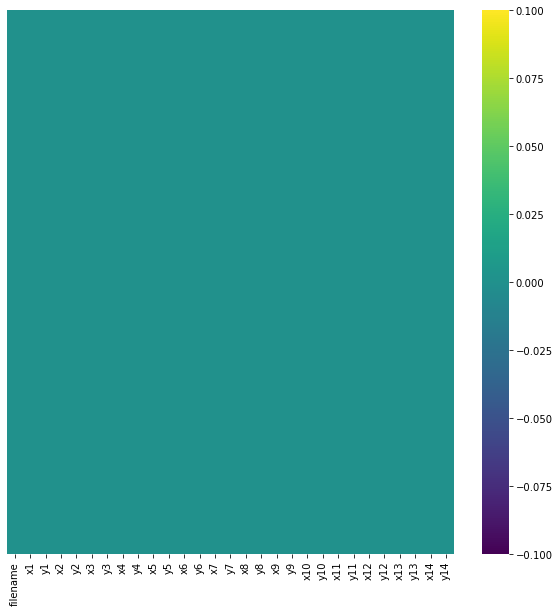

In [3]:
plt.figure(figsize=(10,10))
sns.heatmap(train.isnull(), yticklabels=False, cmap='viridis');

Отлично! Пропущенных значений нет.

In [4]:
print(f'Количество строк в датасете: {train.shape[0]}')

Количество строк в датасете: 5000


Видим, что для тренировки нейросети есть только 5000 изображений, что достаточно немного. Вероятнее всего придется произвести аугментацию данных для увелечения количества тренировочных образцов.

Поскольку в первом столбце датафрейма у нас указан путь к файлу, а должна быть матрица изображения, то создадим функцию, которая будет принимать на вход путь к изображению и возвращать матрицу. Оптимальные параметры входного изображения примем за **96x96**.

In [5]:
def img_to_matrix(path):
    img = image.load_img('train/' + path, target_size=(96, 96))
    img = image.img_to_array(img)
    img = img.reshape(96,96,3)
    img = img / 255
    return img

Так как ключевые точки даны для исходного изображения с координатами n и m, то при сжатии изображения необходимо изменить и координаты точек. Поскольку размер входного изображения 96x96. Формула для этого выглядит следующим образом:
<center> $$X_1 = x_1 \cdot \frac{96}{width}, где:$$ </center>

- X<font size="1">1</font> - новая координата по оси x
- x<font size="1">1</font> - старая координата по оси x
- 96 - ширина нового изображения
- width - ширина старого изображения

Для изменения координаты по оси y формула выглядит аналогичным образом. Функция для изменения координат точек написана ниже.

In [6]:
def img_params(row):
    img = image.load_img('train/' + row['filename'])
    x_transform = img.width
    y_transform = img.height
    for i in row.index:
        if 'x' in i:
            row[i] =  row[i] * 96 / x_transform
        elif 'y' in i:
            row[i] =  row[i] * 96 / y_transform
    return row

In [7]:
train = train.apply(img_params, axis=1)

In [8]:
train.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,05317.jpg,11.162791,24.558140,28.130233,17.413953,64.744186,16.074419,76.353488,20.093023,17.413953,...,70.995349,29.023256,50.455814,45.990698,35.274419,66.083721,50.455814,66.083721,63.851163,62.958140
1,04767.jpg,14.571429,27.428571,33.428571,23.142857,48.000000,18.857143,69.428571,13.714286,17.142857,...,73.714286,24.000000,48.000000,56.571429,38.571429,68.571429,50.571429,68.571429,63.428571,65.142857
2,05241.jpg,16.246154,21.661538,34.461538,21.661538,58.584615,20.184615,69.907692,20.184615,16.246154,...,70.892308,27.569231,46.276923,49.723077,36.430769,66.461538,43.815385,66.461538,55.138462,65.476923
3,03849.jpg,14.288372,23.367442,33.041860,21.283721,57.897674,19.200000,76.948837,18.604651,22.772093,...,69.506977,27.981395,48.818605,50.455814,35.869767,67.125581,49.860465,67.423256,62.362791,65.637209
4,00952.jpg,15.600000,22.800000,36.000000,19.200000,61.200000,20.400000,79.200000,19.200000,21.600000,...,70.800000,27.600000,46.800000,51.600000,37.200000,67.200000,49.200000,67.200000,58.800000,66.000000


Видно, что все координаты в датасете поменяли свое значение.

Теперь изменим значение в первом столбце заменив путь к файлу матрицей изображения и переименуем колонку.

In [9]:
%%time
train['filename'] = train['filename'].apply(img_to_matrix)
train = train.rename(columns={'filename': 'image'})

Wall time: 8.75 s


In [10]:
train.head(3)

,image,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,"[[[0.8117647, 0.8117647, 0.8117647], [0.803921...",11.162791,24.558140,28.130233,17.413953,64.744186,16.074419,76.353488,20.093023,17.413953,...,70.995349,29.023256,50.455814,45.990698,35.274419,66.083721,50.455814,66.083721,63.851163,62.958140
1,"[[[0.54509807, 0.4392157, 0.35686275], [0.5372...",14.571429,27.428571,33.428571,23.142857,48.000000,18.857143,69.428571,13.714286,17.142857,...,73.714286,24.000000,48.000000,56.571429,38.571429,68.571429,50.571429,68.571429,63.428571,65.142857
2,"[[[0.13333334, 0.13725491, 0.15294118], [0.345...",16.246154,21.661538,34.461538,21.661538,58.584615,20.184615,69.907692,20.184615,16.246154,...,70.892308,27.569231,46.276923,49.723077,36.430769,66.461538,43.815385,66.461538,55.138462,65.476923


In [11]:
print(train['image'][0].shape)

(96, 96, 3)


Мы убедились в том, что датасет готов для обучения нейросети и размер фотографии 96x96. Чтобы визуализировать строки из датафрейма напишем функцию, принимающую на вход серию - запись датафрейма и возвращающая изображение с отмеченными на нем ключевыми точками.

In [12]:
def img_with_keypoints(row):
    image = row['image']
    keypoints = list(row[1::])
    fig, axis = plt.subplots()
    x = [keypoints[x] for x in range(len(keypoints)) if x % 2 == 0]
    y = [keypoints[x] for x in range(len(keypoints)) if x % 2 != 0]
    axis.scatter(x, y, c='r')
    axis.imshow(image)

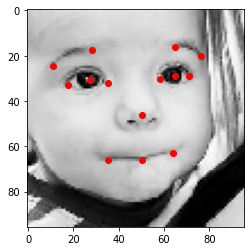

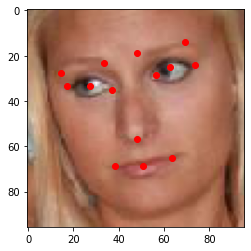

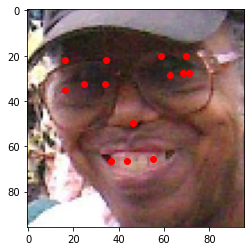

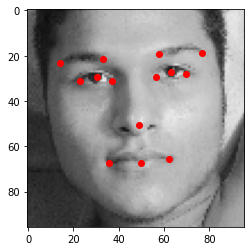

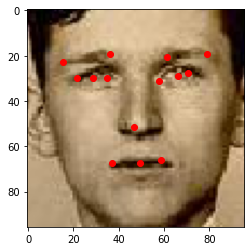

In [13]:
for i in range(5):
    img_with_keypoints(train.iloc[i])

## Подбор модели

### Модель №1

Начнем с самой простой модели и без аугментации данных.

In [14]:
model1 = Sequential()
model1.add(Input(shape=(96, 96, 3)))
model1.add(Flatten())
model1.add(Dense(units=100, activation='relu'))
model1.add(Dense(units=28, activation=None))

Перед тем как отдать данные нейросети их нужно привести к определенному формату. Напишем для этого функцию.

In [15]:
def format_dataset(dataframe):
    X = np.array([x for x in dataframe['image']])
    y = dataframe.drop('image', axis=1).values
    return X, y

Определим тренировочные и валидационные данные.
- Тренировочные данные - 4400 образцов
- Валидационные данные - 600 образцов

In [16]:
train_dataframe = train[0:4400]
test_dataframe = train[4400:5000]

In [17]:
X_train, y_train = format_dataset(train_dataframe)
X_test, y_test = format_dataset(test_dataframe)

Для предотвращения переобучения определим EarlyStopping и скомпилируем модель.

In [18]:
early_stopping = EarlyStopping(monitor='val_mse', patience=10)
model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

In [19]:
model1.fit(X_train, y_train,
           epochs=100,
           batch_size=128,
           verbose=1,
           validation_data=(X_test, y_test),
           callbacks=[early_stopping])

Epoch 1/100
35/35 [==============================] - 2s 38ms/step - loss: 653.0933 - mse: 653.0933 - mae: 19.2061 - val_loss: 169.8160 - val_mse: 169.8160 - val_mae: 9.7484
Epoch 2/100
35/35 [==============================] - 1s 20ms/step - loss: 171.5273 - mse: 171.5273 - mae: 9.8654 - val_loss: 149.7561 - val_mse: 149.7561 - val_mae: 9.0517
Epoch 3/100
35/35 [==============================] - 1s 21ms/step - loss: 155.4000 - mse: 155.4000 - mae: 9.3101 - val_loss: 143.3416 - val_mse: 143.3416 - val_mae: 8.8426
Epoch 4/100
35/35 [==============================] - 1s 20ms/step - loss: 141.0159 - mse: 141.0159 - mae: 8.8561 - val_loss: 134.0263 - val_mse: 134.0263 - val_mae: 8.5390
Epoch 5/100
35/35 [==============================] - 1s 21ms/step - loss: 136.6183 - mse: 136.6183 - mae: 8.6778 - val_loss: 127.4603 - val_mse: 127.4603 - val_mae: 8.3051
Epoch 6/100
35/35 [==============================] - 1s 21ms/step - loss: 130.8256 - mse: 130.8256 - mae: 8.4481 - val_loss: 123.5949 - val

35/35 [==============================] - 1s 21ms/step - loss: 56.4108 - mse: 56.4108 - mae: 5.4023 - val_loss: 88.3767 - val_mse: 88.3767 - val_mae: 6.9451
Epoch 50/100
35/35 [==============================] - 1s 21ms/step - loss: 55.7484 - mse: 55.7484 - mae: 5.3644 - val_loss: 79.4330 - val_mse: 79.4330 - val_mae: 6.3047
Epoch 51/100
35/35 [==============================] - 1s 21ms/step - loss: 58.4657 - mse: 58.4657 - mae: 5.4637 - val_loss: 76.5854 - val_mse: 76.5854 - val_mae: 6.2373
Epoch 52/100
35/35 [==============================] - 1s 21ms/step - loss: 55.1737 - mse: 55.1737 - mae: 5.3289 - val_loss: 75.8529 - val_mse: 75.8529 - val_mae: 6.2067
Epoch 53/100
35/35 [==============================] - 1s 21ms/step - loss: 52.3501 - mse: 52.3501 - mae: 5.1250 - val_loss: 82.8036 - val_mse: 82.8036 - val_mae: 6.6285
Epoch 54/100
35/35 [==============================] - 1s 20ms/step - loss: 54.0719 - mse: 54.0719 - mae: 5.2662 - val_loss: 80.0856 - val_mse: 80.0856 - val_mae: 6.4745

35/35 [==============================] - 1s 20ms/step - loss: 33.1223 - mse: 33.1223 - mae: 4.0373 - val_loss: 66.4840 - val_mse: 66.4840 - val_mae: 5.8309
Epoch 98/100
35/35 [==============================] - 1s 21ms/step - loss: 32.8752 - mse: 32.8752 - mae: 4.0267 - val_loss: 66.2521 - val_mse: 66.2521 - val_mae: 5.8043
Epoch 99/100
35/35 [==============================] - 1s 20ms/step - loss: 29.2549 - mse: 29.2549 - mae: 3.8072 - val_loss: 66.3107 - val_mse: 66.3107 - val_mae: 5.8151
Epoch 100/100
35/35 [==============================] - 1s 20ms/step - loss: 33.9506 - mse: 33.9506 - mae: 4.1335 - val_loss: 66.0059 - val_mse: 66.0059 - val_mae: 5.8373


Также определим функцию, которая будет рисовать график изменение заданной метрики качества по эпохам.

In [20]:
def plot_model_loss(model, metric='mse'):
    plt.figure(figsize=(10,6))
    plt.plot(model[metric])
    plt.plot(model[f'val_{metric}'])
    plt.title(f'{metric.upper()} vs Epoch')
    plt.ylabel(metric.upper())
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc=1)
    plt.show()
    print(f'Среднее значение {metric} на валидационном сете за последние 10 эпох:', model[f'val_{metric}'].tail(10).mean())

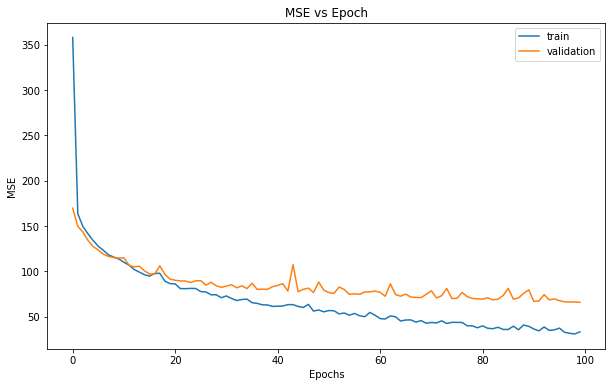

Среднее значение mse на валидационном сете за последние 10 эпох: 67.99517669677735


In [21]:
model1_history = pd.DataFrame(model1.history.history)
plot_model_loss(model1_history)

### Модель №2

#### Аугментация данных

Архитектура второй модели будет точно такая же, как и у первой. Однако, на этот раз датасет будет больше.

In [22]:
transformer1 = A.Compose([A.HorizontalFlip(p=0.5)],
                         keypoint_params=A.KeypointParams(format='xy'))

transformer1 переворачивает изображение по вертикали.

In [23]:
transformer2 = A.Compose([A.Rotate(limit=45),
                          A.RandomBrightnessContrast(p=0.3)],
                         keypoint_params=A.KeypointParams(format='xy'))

transformer2 поворачивает изображение на угол +- 45° и добавляет либо отнимает случайное значение яркости и контраста в диапазоне 30% от исходного.

In [24]:
def augmentation_adder(transformer, row):
    image = row['image']
    keypoints = np.array([list(row[1::])]).reshape(14, 2)
    transformed = transformer(image=image, keypoints=keypoints)
    transformed_image = transformed['image']
    transformed_keypoints = transformed['keypoints']
    return [transformed_image, *keypoints.reshape(1,28)[0]]

In [25]:
%%time
for i in range(len(train)):
    train.loc[len(train)] = augmentation_adder(transformer1, train.iloc[i])

Wall time: 21.8 s


In [26]:
train.shape

(10000, 29)

После вертикального трансформа всех изображений их общее количество увеличилось в двое с 5 до 10 тысяч. То есть, для каждого уже имеющегося изображения сгенерировалось одно новое - его "зеркальная" копия. 

In [27]:
%%time
for i in range(len(train)):
    train.loc[len(train)] = augmentation_adder(transformer2, train.iloc[i])

Wall time: 52.2 s


In [28]:
train.shape

(20000, 29)

После второго трансформа общее количество изображений также возросло вдвое. Теперь датасет состоит из 20.000 изображений.

Создадим новые сеты данных для обучения и валидации, предварительно перемешав данные.

In [29]:
train = train.sample(frac=1).reset_index(drop=True)

In [30]:
train_dataframe = train[0:16000]
test_dataframe = train[16000:20000]

In [31]:
X_train, y_train = format_dataset(train_dataframe)
X_test, y_test = format_dataset(test_dataframe)

In [32]:
model2 = Sequential()
model2.add(Input(shape=(96, 96, 3)))
model2.add(Flatten())
model2.add(Dense(units=100, activation='relu'))
model2.add(Dense(units=28, activation=None))

model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

In [33]:
model2.fit(X_train, y_train,
           epochs=100,
           batch_size=128,
           verbose=1,
           validation_data=(X_test, y_test),
           callbacks=[early_stopping])

Epoch 1/100
125/125 [==============================] - 3s 25ms/step - loss: 375.2520 - mse: 375.2520 - mae: 14.0405 - val_loss: 156.8090 - val_mse: 156.8090 - val_mae: 9.3144
Epoch 2/100
125/125 [==============================] - 3s 24ms/step - loss: 153.7312 - mse: 153.7312 - mae: 9.2619 - val_loss: 136.6562 - val_mse: 136.6562 - val_mae: 8.6640
Epoch 3/100
125/125 [==============================] - 3s 24ms/step - loss: 134.6665 - mse: 134.6665 - mae: 8.6051 - val_loss: 126.3734 - val_mse: 126.3734 - val_mae: 8.2925
Epoch 4/100
125/125 [==============================] - 3s 24ms/step - loss: 124.6668 - mse: 124.6668 - mae: 8.2610 - val_loss: 115.6112 - val_mse: 115.6112 - val_mae: 7.8621
Epoch 5/100
125/125 [==============================] - 3s 24ms/step - loss: 112.8747 - mse: 112.8747 - mae: 7.8298 - val_loss: 115.8813 - val_mse: 115.8813 - val_mae: 8.0117
Epoch 6/100
125/125 [==============================] - 3s 24ms/step - loss: 106.2884 - mse: 106.2884 - mae: 7.5477 - val_loss: 11

Epoch 49/100
125/125 [==============================] - 3s 24ms/step - loss: 40.3306 - mse: 40.3306 - mae: 4.5599 - val_loss: 53.1251 - val_mse: 53.1251 - val_mae: 5.2154
Epoch 50/100
125/125 [==============================] - 3s 23ms/step - loss: 39.6070 - mse: 39.6070 - mae: 4.5040 - val_loss: 52.7705 - val_mse: 52.7705 - val_mae: 5.1996
Epoch 51/100
125/125 [==============================] - 3s 24ms/step - loss: 37.7656 - mse: 37.7656 - mae: 4.3854 - val_loss: 59.4437 - val_mse: 59.4437 - val_mae: 5.5993
Epoch 52/100
125/125 [==============================] - 3s 24ms/step - loss: 38.3777 - mse: 38.3777 - mae: 4.4459 - val_loss: 50.3679 - val_mse: 50.3679 - val_mae: 5.0451
Epoch 53/100
125/125 [==============================] - 3s 24ms/step - loss: 38.1328 - mse: 38.1328 - mae: 4.4071 - val_loss: 50.5995 - val_mse: 50.5995 - val_mae: 5.1052
Epoch 54/100
125/125 [==============================] - 3s 24ms/step - loss: 36.2950 - mse: 36.2950 - mae: 4.3154 - val_loss: 49.6722 - val_mse: 

Epoch 97/100
125/125 [==============================] - 3s 25ms/step - loss: 23.5199 - mse: 23.5199 - mae: 3.5486 - val_loss: 37.8607 - val_mse: 37.8607 - val_mae: 4.3702
Epoch 98/100
125/125 [==============================] - 3s 23ms/step - loss: 21.6296 - mse: 21.6296 - mae: 3.3561 - val_loss: 39.0125 - val_mse: 39.0125 - val_mae: 4.4922
Epoch 99/100
125/125 [==============================] - 3s 24ms/step - loss: 24.0837 - mse: 24.0837 - mae: 3.5930 - val_loss: 42.8149 - val_mse: 42.8149 - val_mae: 4.7283
Epoch 100/100
125/125 [==============================] - 3s 24ms/step - loss: 24.1136 - mse: 24.1136 - mae: 3.5921 - val_loss: 37.1532 - val_mse: 37.1532 - val_mae: 4.3433


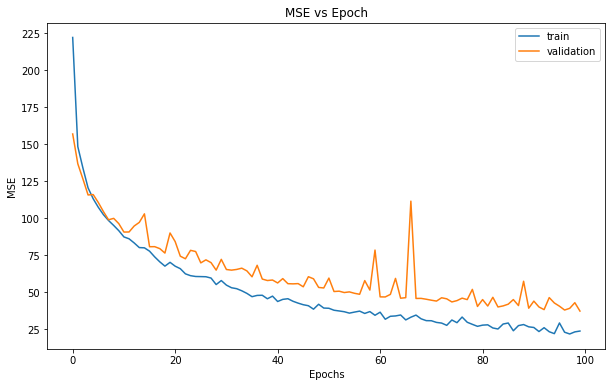

Среднее значение mse на валидационном сете за последние 10 эпох: 40.81144027709961


In [34]:
model2_history = pd.DataFrame(model2.history.history)
plot_model_loss(model2_history)

## Модель №3

Вариация архитектуры LeNet5

In [35]:
model3 = Sequential()

model3.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(96,96,3)))
model3.add(AveragePooling2D())

model3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model3.add(AveragePooling2D())

model3.add(Flatten())

model3.add(Dense(units=120, activation='relu'))

model3.add(Dense(units=84, activation='relu'))

model3.add(Dense(units=28, activation=None))

In [36]:
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

In [37]:
model3.fit(X_train, y_train,
           epochs=200,
           batch_size=64,
           verbose=1,
           validation_data=(X_test, y_test),
           callbacks=[early_stopping])

Epoch 1/200
250/250 [==============================] - 22s 88ms/step - loss: 412.2159 - mse: 412.2159 - mae: 13.0214 - val_loss: 28.4753 - val_mse: 28.4753 - val_mae: 3.5974
Epoch 2/200
250/250 [==============================] - 20s 80ms/step - loss: 28.1570 - mse: 28.1570 - mae: 3.5556 - val_loss: 27.9670 - val_mse: 27.9670 - val_mae: 3.5790
Epoch 3/200
250/250 [==============================] - 20s 79ms/step - loss: 27.6618 - mse: 27.6618 - mae: 3.5113 - val_loss: 27.0311 - val_mse: 27.0311 - val_mae: 3.4659
Epoch 4/200
250/250 [==============================] - 19s 74ms/step - loss: 27.4882 - mse: 27.4882 - mae: 3.4991 - val_loss: 26.7156 - val_mse: 26.7156 - val_mae: 3.4473
Epoch 5/200
250/250 [==============================] - 19s 74ms/step - loss: 27.0262 - mse: 27.0262 - mae: 3.4536 - val_loss: 26.6600 - val_mse: 26.6600 - val_mae: 3.4541
Epoch 6/200
250/250 [==============================] - 19s 75ms/step - loss: 26.3581 - mse: 26.3581 - mae: 3.3834 - val_loss: 27.4432 - val_ms

Epoch 49/200
250/250 [==============================] - 19s 77ms/step - loss: 7.9516 - mse: 7.9516 - mae: 2.0770 - val_loss: 17.4731 - val_mse: 17.4731 - val_mae: 2.8444
Epoch 50/200
250/250 [==============================] - 20s 81ms/step - loss: 7.5537 - mse: 7.5537 - mae: 2.0192 - val_loss: 16.7788 - val_mse: 16.7788 - val_mae: 2.7518
Epoch 51/200
250/250 [==============================] - 20s 79ms/step - loss: 7.5021 - mse: 7.5021 - mae: 2.0138 - val_loss: 16.6635 - val_mse: 16.6635 - val_mae: 2.7277
Epoch 52/200
250/250 [==============================] - 19s 78ms/step - loss: 7.2810 - mse: 7.2810 - mae: 1.9837 - val_loss: 17.6119 - val_mse: 17.6119 - val_mae: 2.8162
Epoch 53/200
250/250 [==============================] - 20s 81ms/step - loss: 7.0354 - mse: 7.0354 - mae: 1.9478 - val_loss: 17.0988 - val_mse: 17.0988 - val_mae: 2.7527
Epoch 54/200
250/250 [==============================] - 20s 80ms/step - loss: 6.9283 - mse: 6.9283 - mae: 1.9407 - val_loss: 17.6509 - val_mse: 17.650

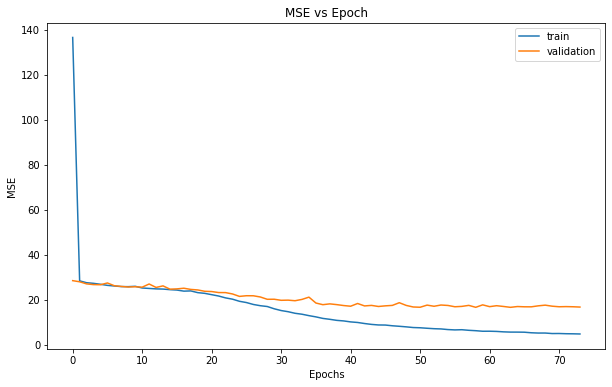

Среднее значение mse на валидационном сете за последние 10 эпох: 17.015970993041993


In [38]:
model3_history = pd.DataFrame(model3.history.history)
plot_model_loss(model3_history)

Весьма странный график, но значение лучше, чем в предыдущих двух моделях.

## Модель №4

А теперь архитектура побольше:)

Думаю, что эту архитектуру можно считать чем-то в роде sota

Создаем и компилируем модель

In [39]:
model4 = Sequential()

model4.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,3)))
model4.add(LeakyReLU(alpha = 0.1))
model4.add(BatchNormalization())

model4.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model4.add(LeakyReLU(alpha = 0.1))
model4.add(BatchNormalization())
model4.add(MaxPool2D(pool_size=(2, 2)))

model4.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model4.add(LeakyReLU(alpha = 0.1))
model4.add(BatchNormalization())

model4.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model4.add(LeakyReLU(alpha = 0.1))
model4.add(BatchNormalization())
model4.add(MaxPool2D(pool_size=(2, 2)))

model4.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model4.add(LeakyReLU(alpha = 0.1))
model4.add(BatchNormalization())

model4.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model4.add(LeakyReLU(alpha = 0.1))
model4.add(BatchNormalization())
model4.add(MaxPool2D(pool_size=(2, 2)))

model4.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model4.add(BatchNormalization())
model4.add(LeakyReLU(alpha = 0.1))
model4.add(BatchNormalization())

model4.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model4.add(LeakyReLU(alpha = 0.1))
model4.add(BatchNormalization())
model4.add(MaxPool2D(pool_size=(2, 2)))

model4.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model4.add(LeakyReLU(alpha = 0.1))
model4.add(BatchNormalization())

model4.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model4.add(LeakyReLU(alpha = 0.1))
model4.add(BatchNormalization())
model4.add(MaxPool2D(pool_size=(2, 2)))

model4.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model4.add(LeakyReLU(alpha = 0.1))
model4.add(BatchNormalization())

model4.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model4.add(LeakyReLU(alpha = 0.1))
model4.add(BatchNormalization())


model4.add(Flatten())
model4.add(Dense(512,activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(28))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 96, 96, 32)        864       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)       

In [40]:
model_checkpoint = ModelCheckpoint('best_model4.h5', monitor='val_mse', verbose=1, save_best_only=True, save_weights_only=True)

In [41]:
model4.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mse', 'mae'])

In [43]:
model4.fit(X_train, y_train,
           epochs=60,
           steps_per_epoch=200,
           batch_size=64,
           verbose=1,
           validation_data=(X_test, y_test),
           callbacks=[early_stopping, model_checkpoint])

Epoch 1/60
200/200 [==============================] - 415s 2s/step - loss: 81.3905 - mse: 81.3905 - mae: 6.8408 - val_loss: 33.7205 - val_mse: 33.7205 - val_mae: 4.1626

Epoch 00001: val_mse improved from inf to 33.72047, saving model to best_model4.h5
Epoch 2/60
200/200 [==============================] - 414s 2s/step - loss: 52.3314 - mse: 52.3314 - mae: 5.3930 - val_loss: 30.9884 - val_mse: 30.9884 - val_mae: 3.9420

Epoch 00002: val_mse improved from 33.72047 to 30.98836, saving model to best_model4.h5
Epoch 3/60
200/200 [==============================] - 413s 2s/step - loss: 46.9641 - mse: 46.9641 - mae: 5.0694 - val_loss: 37.1367 - val_mse: 37.1367 - val_mae: 4.5527

Epoch 00003: val_mse did not improve from 30.98836
Epoch 4/60
200/200 [==============================] - 413s 2s/step - loss: 42.6562 - mse: 42.6562 - mae: 4.8266 - val_loss: 24.1249 - val_mse: 24.1249 - val_mae: 3.4105

Epoch 00004: val_mse improved from 30.98836 to 24.12494, saving model to best_model4.h5
Epoch 5/60

200/200 [==============================] - 411s 2s/step - loss: 22.0308 - mse: 22.0308 - mae: 3.5574 - val_loss: 14.2159 - val_mse: 14.2159 - val_mae: 2.6250

Epoch 00036: val_mse did not improve from 13.78822
Epoch 37/60
200/200 [==============================] - 411s 2s/step - loss: 22.4149 - mse: 22.4149 - mae: 3.5903 - val_loss: 13.1257 - val_mse: 13.1257 - val_mae: 2.4864

Epoch 00037: val_mse improved from 13.78822 to 13.12575, saving model to best_model4.h5
Epoch 38/60
200/200 [==============================] - 410s 2s/step - loss: 22.1559 - mse: 22.1559 - mae: 3.5449 - val_loss: 15.1175 - val_mse: 15.1175 - val_mae: 2.7447

Epoch 00038: val_mse did not improve from 13.12575
Epoch 39/60
200/200 [==============================] - 410s 2s/step - loss: 22.4780 - mse: 22.4780 - mae: 3.5876 - val_loss: 14.0025 - val_mse: 14.0025 - val_mae: 2.5639

Epoch 00039: val_mse did not improve from 13.12575
Epoch 40/60
200/200 [==============================] - 410s 2s/step - loss: 21.9332 - m

К сожалению, мощностей у меня хватило только на 60 эпох с батчем 64 и я более чем уверен, что при 100 эпохах, 128 batch_size и немного большем датасете можно довести среднеквадратичную ошибку в район 8-9. На данный момент, лучшее значение mse - 12.48787, а средняя абсолютная ошибка составляет 2.397

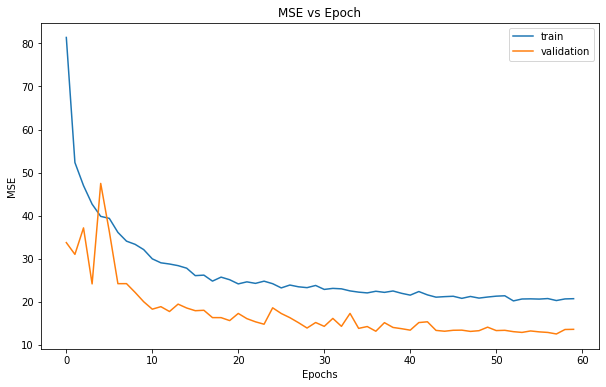

Среднее значение mse на валидационном сете за последние 10 эпох: 13.109005165100097


In [44]:
model4_history = pd.DataFrame(model4.history.history)
plot_model_loss(model4_history)

## Предсказания значений для тестовых данных

Создадим датасет, состоящий из колонки с названием всех файлов  в тесте и продублируем функции для перевода изображения в матрицу (потому что изначально я не подумал о масштабировании данной функции).

In [45]:
test_data = pd.DataFrame({'path': os.listdir('test')})

In [46]:
def test_img_to_matrix(path):
    img = image.load_img('test/' + path, target_size=(96, 96))
    img = image.img_to_array(img)
    img = img.reshape(96,96,3)
    img = img / 255
    return img

In [48]:
test_data['path'] = test_data['path'].apply(test_img_to_matrix)
test_data.columns = ['image']

Создадим датасет с предсказаниями и запишем туда все значения точек для тестовых изображений

In [49]:
preds_df = pd.DataFrame(columns=train.columns[1::])

for i in range(len(test_data)):
    to_predict = np.array([x for x in test_data.values[i][0]])
    preds = model4.predict(to_predict.reshape(1,96,96,3))
    preds_df.loc[i] = preds.flatten()

Соединим матрицу изображения с предсказанными значениями координат и посмотрим на результат.

In [50]:
result_df = pd.concat([test_data, preds_df], axis=1)
result_df.head()

,image,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,"[[[0.7372549, 0.70980394, 0.63529414], [0.9450...",15.126542,24.316648,35.767937,19.410229,57.073780,18.090868,76.397713,20.107012,21.026413,...,72.891068,28.522392,50.138138,45.400745,35.941734,66.075386,50.868023,64.760277,64.235504,63.476398
1,"[[[0.6431373, 0.5137255, 0.4392157], [0.819607...",16.152241,21.615103,39.196381,19.227098,61.681705,20.082426,81.254112,22.667051,21.963739,...,76.665497,30.704010,52.720161,49.155319,34.582172,65.818710,50.977474,66.830048,64.764153,65.673325
2,"[[[0.1882353, 0.16862746, 0.14509805], [0.2235...",15.705367,16.258522,37.813824,15.202969,58.848194,16.026751,77.981216,17.449474,20.917475,...,73.989594,24.727299,50.279312,44.849819,33.311134,59.003765,48.780792,60.366810,61.946640,59.088562
3,"[[[0.27058825, 0.16470589, 0.09019608], [0.286...",11.829849,28.127630,32.122280,22.986647,53.177628,18.866732,72.849716,16.449762,18.907747,...,70.435814,24.985380,50.292366,50.751389,38.473061,68.802162,53.374043,67.366776,66.795242,62.646084
4,"[[[0.6862745, 0.4392157, 0.2784314], [0.764705...",19.086868,20.495733,38.693542,21.088137,58.504204,21.815554,77.772079,22.971258,24.089474,...,73.597145,30.358858,47.903259,51.967506,33.929432,63.640343,48.093414,66.401955,62.552483,64.072037


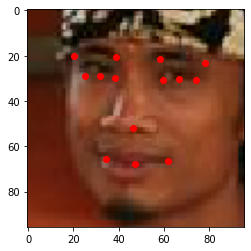

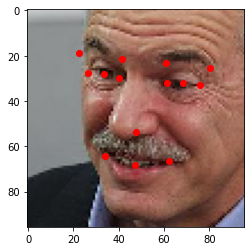

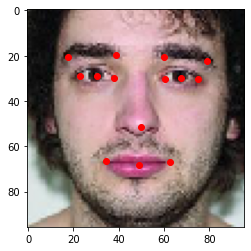

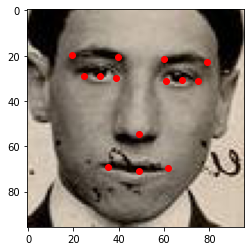

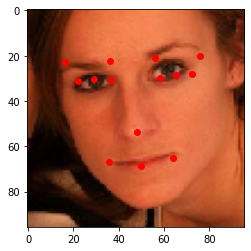

In [58]:
for i in range(5):
    img_with_keypoints(result_df.iloc[randint(0, len(result_df))])

In [59]:
preds_df.to_csv('final_answers.csv')

## Вывод

Задача была решена - нейросеть научилась определять ключевые точки на человеческом лице. Я перебрал 4 модели, последняя из которых дала наилучший результат. Однако, модель недоучена и работает корректно в основном на изображениях с лицом, смотрящим прямо в камеру и повернутым на небольшой угол. В остальных случаях точки иногда выходят за пределы лица (проблема смещения), но с дисперсией все в порядке. При дальнейших доработках модели это стоит учитывать.

Помимо прочего, датасета даже с 20.000 изображений не хватит, чтобы хорошо обучить модель. Его можно расширить, добавив изображения лица, перевернутого на 180°, добавить фотографии с размытием. Также можно засчитить модель от adverserial attacks, добавив в датасет фотографии с шумом или перед загрузкой фотографии в модель убирать из нее весь шум.